#### Tuning XGB Adjuster: Adult Data

In [1]:
from aif360.algorithms.inprocessing.xgb_fairness_adjuster import XGBFairnessAdjuster
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import (
    load_preproc_data_adult,
)

2025-01-18 04:20:47.160384: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-18 04:20:47.172482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737174047.186336   50946 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737174047.190495   50946 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-18 04:20:47.204717: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

/home/ubuntu/miniconda3/envs/aif360/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(


/home/ubuntu/miniconda3/envs/aif360/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_discounted_cumulative_gain, in_dims=(0,))
/home/ubuntu/miniconda3/envs/aif360/lib/python3.11/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or

#### Load dataset and set options

In [2]:
# Get the dataset and split into train and test
dataset_orig = load_preproc_data_adult(protected_attributes=["sex", "race"])
dataset_orig_train, dataset_orig_test = dataset_orig.split(
    [0.9], shuffle=True, seed=1234
)
privileged_groups = [{"sex": 1}]
unprivileged_groups = [{"sex": 0}]

/home/ubuntu/AIF360_dev/aif360/algorithms/preprocessing/optim_preproc_helpers/data_preproc_functions.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['sex'].replace({'Female': 0.0, 'Male': 1.0})


### Learn plan classifier without debiasing

In [3]:
base_settings = {
    "time_budget": 60,  # total running time in seconds
    "metric": "log_loss",
}

In [4]:
plain_model = XGBFairnessAdjuster(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    seed=1234,
    debias=False,
    tune_hyperparameters_base=True,
    tuning_settings_base=base_settings,
    tune_hyperparameters_adjuster=False,
)

In [5]:
plain_model.fit(dataset=dataset_orig_train, test_dataset=dataset_orig_test)

### Apply in-processing algorithm based on adversarial learning

In [6]:
debiased_model = XGBFairnessAdjuster(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    seed=1234,
    debias=True,
    adversary_loss_weight=1.0,
    tune_hyperparameters_base=True,
    tuning_settings_base=base_settings,
    tune_hyperparameters_adjuster=False,
    debug=False,
    task="classification",
)

In [7]:
debiased_model.fit(dataset=dataset_orig_train, test_dataset=dataset_orig_test)

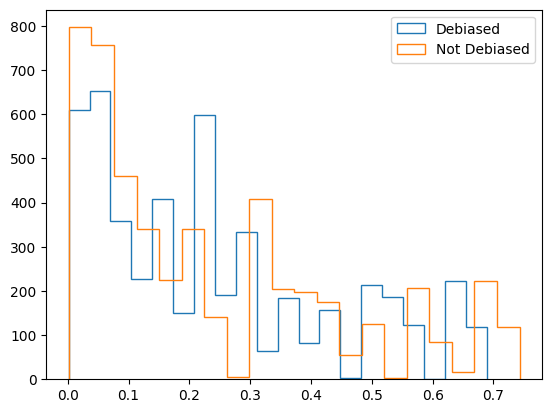

In [8]:
import matplotlib.pyplot as plt

bins = 20
probs_ad = debiased_model.predict_proba(dataset_orig_test)
base_probs = plain_model.predict_proba(dataset_orig_test)
# plt.hist(adjusted_probs, bins=bins, histtype="step", label="Fairness Adjuster")
plt.hist(probs_ad, bins=bins, histtype="step", label="Debiased")
plt.hist(base_probs, bins=bins, histtype="step", label="Not Debiased")
plt.legend()
plt.show()

In [9]:
plain_model.base_estimator.best_config

{'n_estimators': 654,
 'max_leaves': 25,
 'min_child_weight': np.float64(0.003927690266404936),
 'learning_rate': np.float64(0.009301703679887835),
 'subsample': np.float64(0.5489666936183099),
 'colsample_bylevel': np.float64(0.7318217010283135),
 'colsample_bytree': np.float64(0.9159545743841531),
 'reg_alpha': np.float64(0.021236193733879617),
 'reg_lambda': np.float64(0.43724387863433545)}

In [10]:
debiased_model.base_estimator.best_config

{'n_estimators': 654,
 'max_leaves': 25,
 'min_child_weight': np.float64(0.003927690266404936),
 'learning_rate': np.float64(0.009301703679887835),
 'subsample': np.float64(0.5489666936183099),
 'colsample_bylevel': np.float64(0.7318217010283135),
 'colsample_bytree': np.float64(0.9159545743841531),
 'reg_alpha': np.float64(0.021236193733879617),
 'reg_lambda': np.float64(0.43724387863433545)}